In [1]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)


In [2]:
# system libraries

import sys
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# image libraries
import cv2
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
# 

print(tf.__version__)

2.0.0


## Part 1 : Recap of AE

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


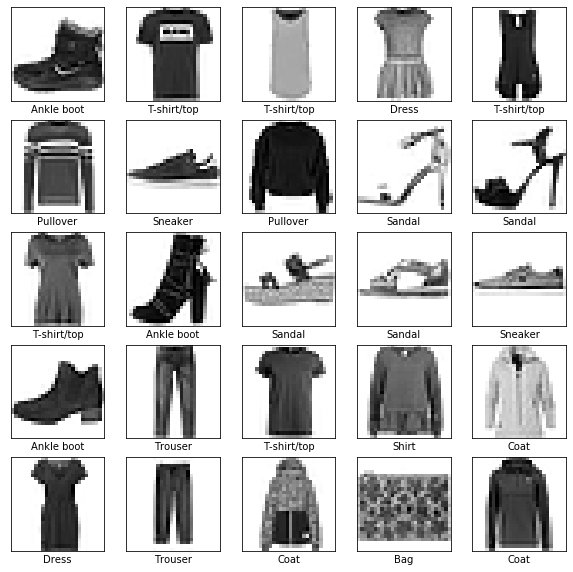

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

# split and normalize
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()

# each pixel is 8 bits so value ranges from 0 to 255
xtrain, xtest = xtrain/255.0, xtest/255.

print(f'X_train shape: {xtrain.shape}, X_test shape: {xtest.shape}')
print(f'y_train shape: {ytrain.shape}, and y_test shape: {ytest.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display 1st 25 garments
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xtrain[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[ytrain[i]])

## Add noise to image

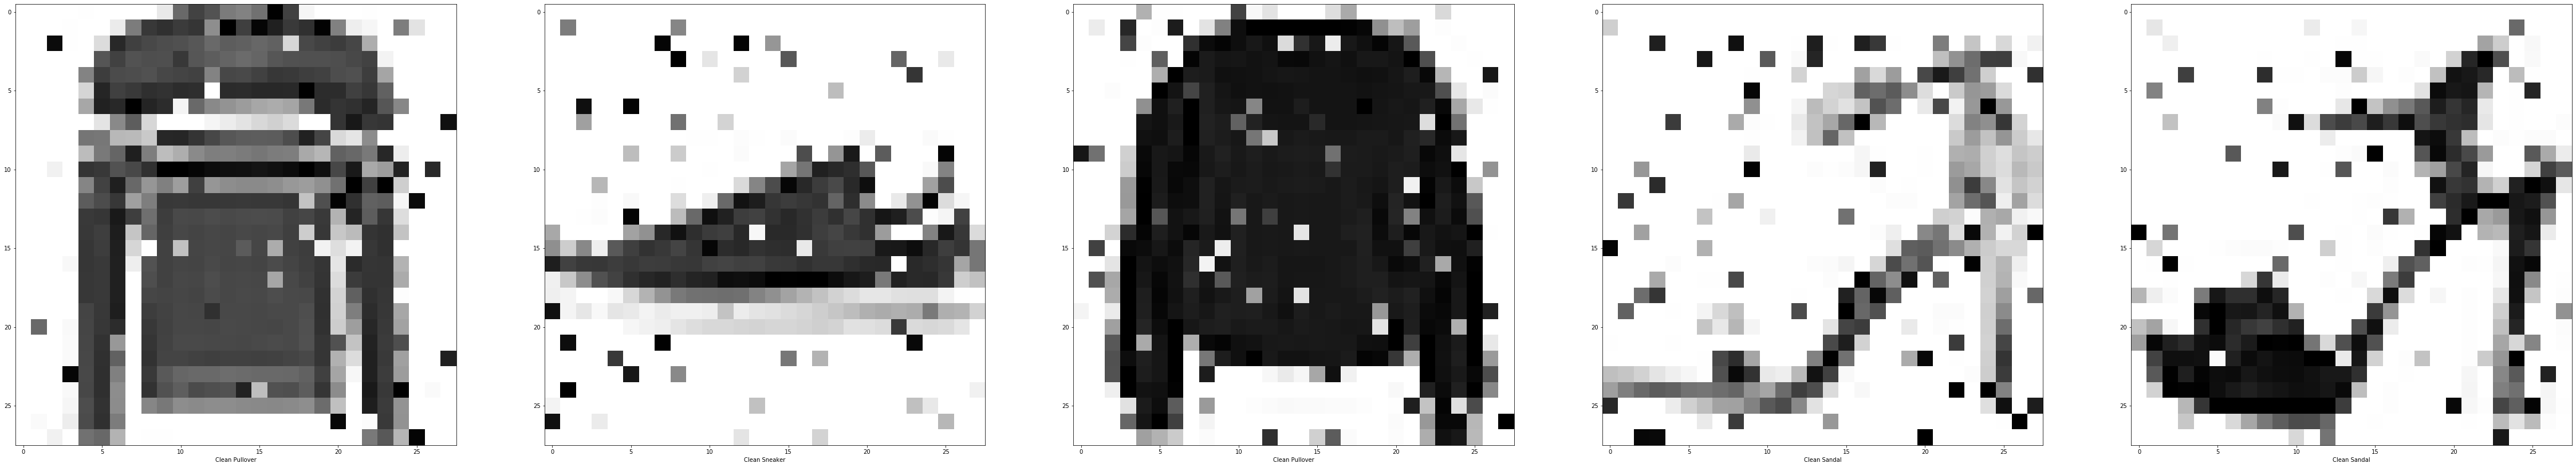

In [4]:
# NNs want the inputs to be 3D
n_samples, h, w = xtrain.shape

xtrain = xtrain.reshape(-1, h, w, 1)
xtest = xtest.reshape(-1, h, w, 1)

# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

xtrain_n = seq_object.augment_images(xtrain * 255) / 255
xtest_n = seq_object.augment_images(xtest * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(xtrain_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[ytrain[i]])

In [5]:
xtrain.shape

(60000, 28, 28, 1)

## Variational AE

### Setup Encoder Network

In [4]:
batch_size = 16
latent_dim = 2 # Number of latent dimension parameters

# encoder parameters
input_img = tf.keras.layers.Input(shape = (784,), name = 'input')
x = tf.keras.layers.Dense(512, activation = 'relu', name = 'intermediate_encoder')(input_img)
x = tf.keras.layers.Dense(2, activation = 'relu', name = 'latent_encoder')(x)


In [5]:
# latent space parameters
z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [6]:
z_mu

<tf.Tensor 'dense/Identity:0' shape=(None, 2) dtype=float32>

In [11]:
# create sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape = (tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

In [14]:
# pass sampling function as lambda to latent distribution
# take sample vector from latent distribuition
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [16]:
# pass latent distribuition sample to decoder as input
decoder_input = tf.keras.layers.Input((2,), name = 'input_decoder')

x = tf.keras.layers.Dense(512, activation = 'relu', name = 'intermediate', input_shape = (2,))(decoder_input)

# Expand to 784 pixels
x = tf.keras.layers.Dense(784, activation = 'sigmoid', name = 'original_decoder')(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [18]:
z_decoded

<tf.Tensor 'model_1/Identity:0' shape=(None, 784) dtype=float32>

In [22]:
# construct a custom layer to calculate the loss

class CustomVariationalLayer(tf.keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction Loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss
    
    # adds custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        return x
        

In [23]:
# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [24]:
# VAE Model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
intermediate_encoder (Dense)    (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
latent_encoder (Dense)          (None, 2)            1026        intermediate_encoder[0][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            6           latent_encoder[0][0]             
____________________________________________________________________________________________

In [25]:
xtrain.shape

(60000, 28, 28)

In [26]:
train_x = xtrain.reshape(-1, 784)
val_x = xtest.reshape(-1,784)

In [27]:
vae.fit(x = train_x, y = None,
       shuffle = True,
       epochs = 4,
       batch_size = batch_size,
       validation_data = (val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 21s 352us/sample - loss: 0.3625 - val_loss: 0.3407
Epoch 2/4
60000/60000 [==============================] - 19s 322us/sample - loss: 0.3387 - val_loss: 0.3371
Epoch 3/4
60000/60000 [==============================] - 19s 324us/sample - loss: 0.3351 - val_loss: 0.3363
Epoch 4/4
60000/60000 [==============================] - 19s 322us/sample - loss: 0.3331 - val_loss: 0.3359


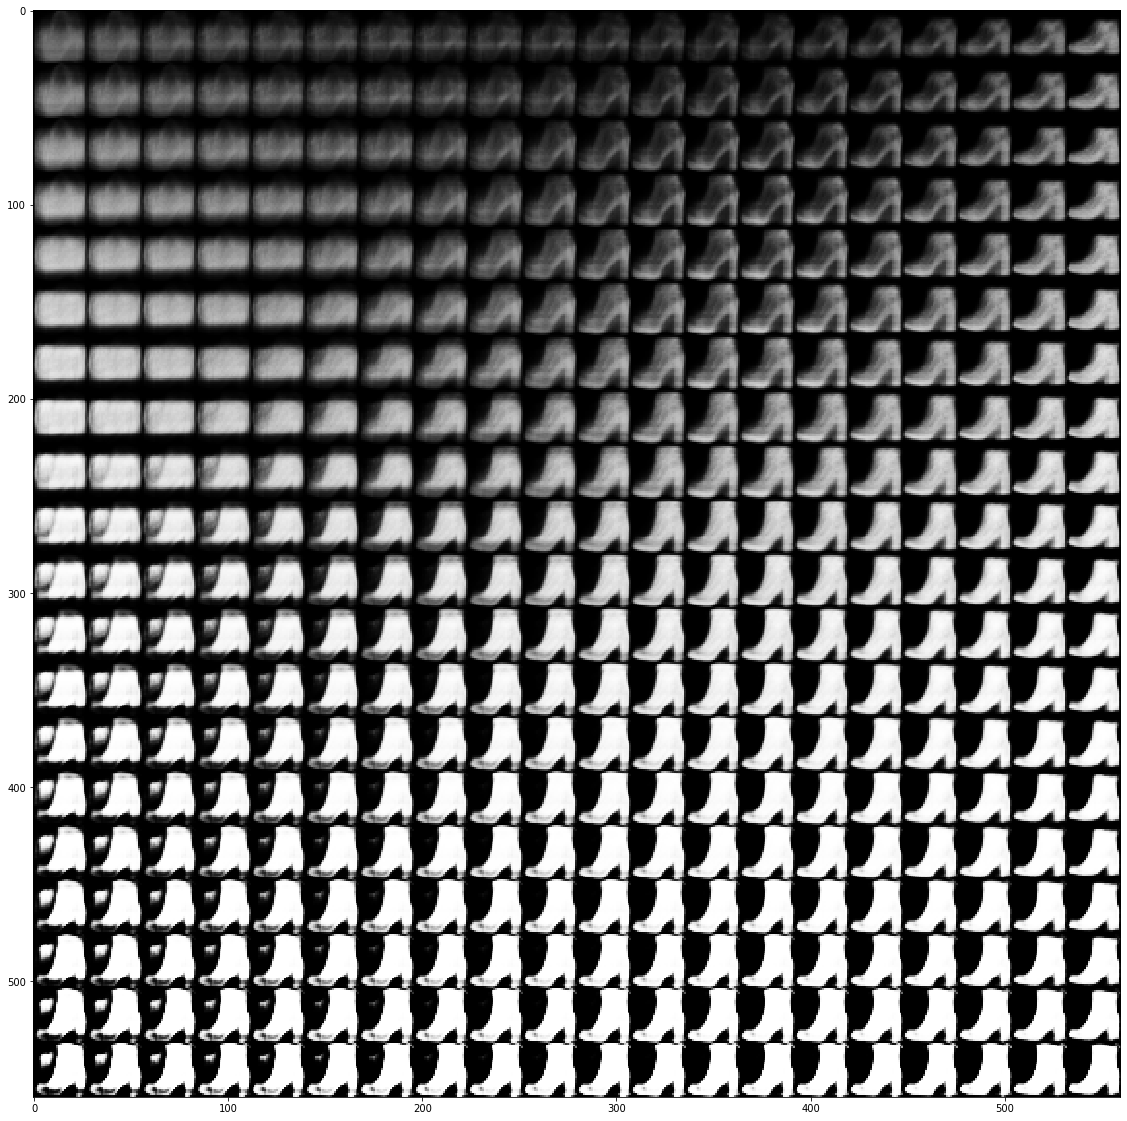

In [28]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()  

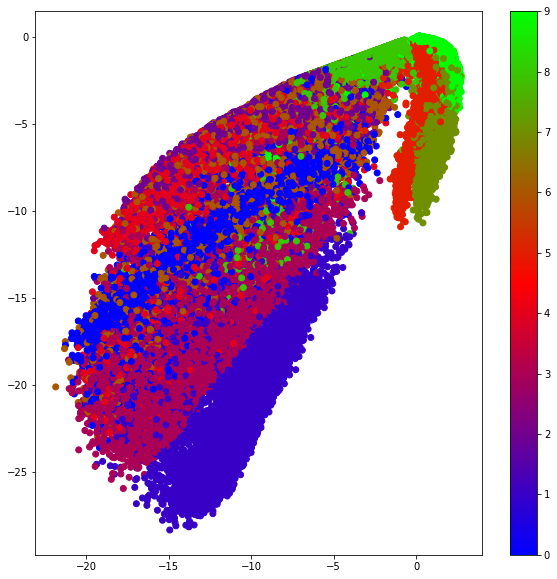

In [31]:
# Translate into latent space
encoder = tf.keras.Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size = batch_size)

plt.figure(figsize = (10,10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c = ytrain, cmap = 'brg')
plt.colorbar()
plt.show()

### Part 2B : Adding CNNs and KL Divergence Loss

#### Generating new fashion!

In [20]:
batch_size = 16
latent_dim = 12  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32,3,padding='same', activation='relu')(input_img)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = tf.keras.backend.int_shape(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

### Setup sampling function

In [21]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])


In [22]:
# instantiate encoder model
encoder = tf.keras.models.Model(input_img, [z_mu, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_23[0][0]                  
____________________________________________________________________________________________

### Setup decoder neural network

In [23]:
shape_before_flattening[1:]

(14, 14, 64)

In [26]:
#Decoder
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')

x = tf.keras.layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = tf.keras.layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = tf.keras.layers.Conv2D(1, 3,
                   padding='same', 
                   activation='sigmoid')(x)

# instantiate decoder model
decoder = tf.keras.models.Model(latent_inputs, x, name='decoder')
decoder.summary()
outputs = decoder(encoder(input_img)[2])


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 12)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 12544)             163072    
_________________________________________________________________
reshape_6 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 181,825
Trainable params: 181,825
Non-trainable params: 0
_________________________________________________________________


### GANs